In [1]:
import lightgbm as lgbm
from pathlib import Path
from tqdm import tqdm
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing, feature_selection, metrics, model_selection, decomposition

import random
from itertools import product
import pickle

import psutil
import warnings
warnings.filterwarnings('ignore')

idx = pd.IndexSlice


In [2]:
input_directory = Path(r"..\\..\\Data\\Input")

feature_directory = Path(r"..\\..\\Data\\Feature")

model_name = "model_lgbm_02"
model_directory = Path()/model_name
model_directory.mkdir(exist_ok=True)


### Import Data

In [3]:
df_data = pd.read_parquet(input_directory/'train_low_mem.parquet', engine='pyarrow').set_index(['time_id','investment_id'])
df_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3141410 entries, (0, 1) to (1219, 3773)
Columns: 302 entries, row_id to f_299
dtypes: float32(301), object(1)
memory usage: 3.6+ GB


In [4]:
df_data = df_data.drop('row_id', axis=1)
df_data.head()

target       f_0       f_1       f_2       f_3  \
time_id investment_id                                                     
0       1             -0.300875  0.932573  0.113691 -0.402206  0.378386   
        2             -0.231040  0.810802 -0.514115  0.742368 -0.616673   
        6              0.568807  0.393974  0.615937  0.567806 -0.607963   
        7             -1.064780 -2.343535 -0.011870  1.874606 -0.606346   
        8             -0.531940  0.842057 -0.262993  2.330030 -0.583422   

                            f_4       f_5       f_6       f_7       f_8  ...  \
time_id investment_id                                                    ...   
0       1             -0.203938 -0.413469  0.965623  1.230508  0.114809  ...   
        2             -0.194255  1.771210  1.428127  1.134144  0.114809  ...   
        6              0.068883 -1.083155  0.979656 -1.125681  0.114809  ...   
        7             -0.586827 -0.815737  0.778096  0.298990  0.114809  ...   
        8             -0.618392 -0.742814 -0.946789  1.230508  0.114809  ...   

                          f_290     f_291     f_292     f_293     f_294  \
time_id investment_id                                                     
0       1              0.366028 -1.095620  0.200075  0.819155  0.941183   
        2             -0.154193  0.912726 -0.734579  0.819155  0.941183   
        6             -0.138020  0.912726 -0.551904 -1.220772 -1.060166   
        7              0.382201  0.912726 -0.266359 -1.220772  0.941183   
        8             -0.170365  0.912726 -0.741355 -1.220772  0.941183   

                          f_295     f_296     f_297     f_298     f_299  
time_id investment_id                                                    
0       1             -0.086764 -1.087009 -1.044826 -0.287605  0.321566  
        2             -0.387617 -1.087009 -0.929529 -0.974060 -0.343624  
        6             -0.219097 -1.087009 -0.612428 -0.113944  0.243608  
        7             -0.609113  0.104928 -0.783423  1.151730 -0.773309  
        8             -0.588445  0.104928  0.753279  1.345611 -0.737624  

[5 rows x 301 columns]

### Feature Engineering

##### Normalization

In [11]:
df_data_norm = df_data.copy()

for i in tqdm(range(300)):
    feature = f'f_{i}'

    # df_data_norm[feature] = df_data[feature].groupby(level='time_id').apply(
    #     lambda x: pd.DataFrame(preprocessing.RobustScaler(quantile_range=(20., 80.)).fit_transform(x.values.reshape(-1, 1)), index=x.index, columns=[f'f_{i}']))

    df_data_norm[feature] = df_data[feature].groupby(level='time_id').apply(
        lambda x: 2*x.rank(pct=True)-1).astype(np.float32)


100%|██████████| 300/300 [08:16<00:00,  1.66s/it]


In [12]:
# df_data_norm.to_parquet(input_directory/'train_norm.parquet')
df_data_norm = pd.read_parquet(input_directory/'train_norm.parquet', engine='pyarrow')

In [6]:
# fig = plt.figure(figsize=(18, 4))
# ax = plt.subplot(121)
# df_data['f_0'].plot(kind='hist', bins=200, ax=ax, title="histgram of raw feature")

# ax = plt.subplot(122)
# df_data_norm['f_0'].plot(kind='hist', bins=200, ax=ax, title="histgram of normalized feature")

### Feature_selection

In [7]:
df_feature_selection = pd.DataFrame()

for i in tqdm(range(300)):
    feature = f'f_{i}'
    df_feature_selection.loc[feature, 'corr'] = np.corrcoef(
        df_data_norm['target'], df_data_norm[feature])[0][1]


100%|██████████| 300/300 [00:16<00:00, 18.47it/s]


In [8]:
n = len(df_data_norm)
rand_k_index = random.sample(range(n), n//50)
rand_k_index.sort()

mi = feature_selection.mutual_info_regression(
    df_data_norm.iloc[rand_k_index, :].filter(like='f_'), df_data_norm.iloc[rand_k_index, :]['target'])
df_feature_selection['mutual_information'] = mi



In [ ]:
feature = {}

In [9]:
selected_feature1 = df_feature_selection[np.abs(
    df_feature_selection['corr']) > 0.03].index
selected_feature2 = df_feature_selection[(
    df_feature_selection['mutual_information']) > 0.03].index
print("seleced feature by corr: ", len(selected_feature1))
print("seleced feature by mutual_information: ", len(selected_feature2))
selected_feature = set(selected_feature1).union(set(selected_feature2))
print("union feature: ", len(selected_feature))

all_feature = set([f'f_{i}' for i in range(300)])
left_feature = all_feature - selected_feature
print("left feature: ", len(left_feature))

seleced feature by corr:  55
seleced feature by mutual_information:  38
union feature:  83
left feature:  217


In [10]:
add_feature = [f'f_{i}' for i in range(300, 305)]
df_data_norm[add_feature] = decomposition.PCA(n_components=5).fit_transform(
    df_data_norm[list(left_feature)])

selected_feature = list(selected_feature.union(set(add_feature)))
print("selected feature: ", len(selected_feature))

selected feature:  88


In [12]:
f = open(model_directory/'pickle_selected_feature', 'wb')
pickle.dump(selected_feature, f)
f.close()

### Split Feature & target

In [13]:
feature = df_data_norm[selected_feature]
target = df_data_norm['target']
target

time_id  investment_id
0        1               -0.300875
         2               -0.231040
         6                0.568807
         7               -1.064780
         8               -0.531940
                            ...   
1219     3768             0.033600
         3769            -0.223264
         3770            -0.559415
         3772             0.009599
         3773             1.212112
Name: target, Length: 3141410, dtype: float32

In [14]:
feature

f_158       f_5      f_78     f_169     f_106  \
time_id investment_id                                                     
0       1              0.667254 -0.354754 -0.858275 -0.058979  0.074824   
        2              0.652289  0.912852 -0.461268  0.691901 -0.677817   
        6              0.182218 -0.706866  0.350352 -0.103873  0.113556   
        7             -0.539613 -0.590669 -0.392606  0.856514 -0.819542   
        8             -0.930458 -0.556338 -0.126761  0.989437 -0.984155   
...                         ...       ...       ...       ...       ...   
1219    3768          -0.557882 -0.383944  0.160558  0.589296 -0.659686   
        3769          -0.862711 -0.132635  0.689354 -0.503200  0.523560   
        3770          -0.137289  0.816172 -0.474113 -0.542176  0.560791   
        3772          -0.209424 -0.544503 -0.119837  0.969168 -0.951134   
        3773           0.794066  0.390925 -0.712042 -0.267597  0.335079   

                          f_159      f_76     f_243     f_194     f_113  ...  \
time_id investment_id                                                    ...   
0       1              0.463908  0.605634  0.379842 -0.317782  0.298415  ...   
        2              0.766725 -0.404930 -0.522007  0.841549  0.829225  ...   
        6             -0.088028  0.268486  0.654930 -0.036972 -0.221831  ...   
        7             -0.263204  0.943662 -0.522007 -0.193662 -0.392606  ...   
        8             -0.800176  0.809859 -0.522007  0.233275 -0.898768  ...   
...                         ...       ...       ...       ...       ...  ...   
1219    3768          -0.549156 -0.187318 -0.251309  0.113438 -0.282141  ...   
        3769          -0.340896  0.279814 -0.251309  0.592205 -0.312391  ...   
        3770           0.770797  0.738802 -0.251309 -0.331588 -0.057592  ...   
        3772           0.831879  0.402560 -0.251309  0.934264  0.577080  ...   
        3773           0.567772 -0.630599  0.579988  0.433973  0.879581  ...   

                           f_86      f_83     f_155     f_265     f_264  \
time_id investment_id                                                     
0       1              0.356514  0.674296  0.071303  0.320423 -0.814261   
        2              0.632923 -0.460387  0.523768  0.720070  0.623239   
        6              0.132923  0.037852 -0.426937 -0.876761 -0.073063   
        7             -0.468310  0.495599 -0.418134 -0.520246  0.988556   
        8             -0.668134  0.722711 -0.288732 -0.882923  0.594630   
...                         ...       ...       ...       ...       ...   
1219    3768          -0.712624  0.217568  0.000582  0.534613  0.141361   
        3769          -0.427574  0.861547 -0.915067 -0.924956  0.359802   
        3770           0.600349 -0.713787  0.206515  0.520070  0.748691   
        3772           0.476440 -0.339151  0.170448  0.462478 -0.086097   
        3773           0.775451  0.139034  0.726585  0.927865 -0.909831   

                          f_271     f_172     f_273      f_79      f_28  
time_id investment_id                                                    
0       1              0.259683  0.657570  0.798415  0.790493  0.059859  
        2              0.578345  0.677817 -0.456866  0.845070  0.468310  
        6              0.176056 -0.203345  0.097711 -0.253521 -0.150528  
        7             -0.113556 -0.909331 -0.569542 -0.411092 -0.817782  
        8             -0.892606 -0.710387 -0.814261 -0.656690 -0.447183  
...                         ...       ...       ...       ...       ...  
1219    3768          -0.158813  0.052356 -0.491565  0.005817 -0.030832  
        3769          -0.805701 -0.340314 -0.904596 -0.438045 -0.542176  
        3770           0.257708  0.215823 -0.161722 -0.410122 -0.379872  
        3772          -0.260617 -0.383362 -0.293775  0.067481  0.762653  
        3773           0.825480  0.956370  0.518906  0.714951  0.913322  

[3141410 rows x 88 columns]

###  Split Train & Test

In [19]:
train_test_ratio = 5

uniquedate = target.index.get_level_values(level='time_id').unique().tolist()
train_start = 0
train_end = uniquedate[int(
    len(uniquedate)*train_test_ratio/(train_test_ratio+1))]
test_start = uniquedate[int(
    len(uniquedate)*train_test_ratio/(train_test_ratio+1))+1]
test_end = 1219


# dates of train, dates of test
print(
    f'train_start: {train_start}, train_end: {train_end}, test_start: {test_start}, test_end: {test_end}')

feature_train = feature.loc[idx[train_start:train_end, :], :]
feature_test = feature.loc[idx[test_start:test_end, :], :]

target_train = target.loc[idx[train_start:train_end, :]]
target_test = target.loc[idx[test_start:test_end, :]]


train_start: 0, train_end: 1018, test_start: 1019, test_end: 1219


### Train Model

In [27]:
def feval_mse_score(preds, lgbm_train):
    labels = lgbm_train.get_label()
    return 'mse', round(metrics.mean_squared_error(y_true=labels, y_pred=preds), 5), False


def feval_mape_score(preds, lgbm_train):
    labels = lgbm_train.get_label()
    return 'mape', round(metrics.mean_absolute_percentage_error(y_true=labels, y_pred=preds), 5), False


def feval_r2_score(preds, lgbm_train):
    labels = lgbm_train.get_label()
    return 'r2_score', round(metrics.r2_score(y_true=labels, y_pred=preds), 5), True


def corr(y_true, y_pred):
    return np.corrcoef(y_true, y_pred)[0][1]


def feval_corr_score(preds, lgbm_train):
    labels = lgbm_train.get_label()
    return 'corr_score', round(corr(y_true=labels, y_pred=preds), 5), True


class MultipleTimeSeriesCV:
    """Generates tuples of train_idx, test_idx pairs
    Assumes the MultiIndex contains levels 'symbol' and 'date'
    purges overlapping outcomes"""

    def __init__(self,
                 n_splits=3,
                 train_period_length=126,
                 test_period_length=21,
                 lookahead=None,
                 date_idx='date',
                 shuffle=False):
        self.n_splits = n_splits
        self.lookahead = lookahead
        self.test_length = test_period_length
        self.train_length = train_period_length
        self.shuffle = shuffle
        self.date_idx = date_idx

    def split(self, X, y=None, groups=None):
        unique_dates = X.index.get_level_values(self.date_idx).unique()
        days = sorted(unique_dates, reverse=True)
        split_idx = []
        for i in range(self.n_splits):
            test_end_idx = i * self.test_length
            test_start_idx = test_end_idx + self.test_length
            train_end_idx = test_start_idx + self.lookahead - 1
            train_start_idx = min(
                train_end_idx + self.train_length + self.lookahead - 1, len(days) - 1)
            split_idx.append([train_start_idx, train_end_idx,
                              test_start_idx, test_end_idx])

        dates = X.reset_index()[[self.date_idx]]
        for train_start, train_end, test_start, test_end in split_idx:
            # print(train_start, train_end)
            train_idx = dates[(dates[self.date_idx] > days[train_start])
                              & (dates[self.date_idx] <= days[train_end])].index
            test_idx = dates[(dates[self.date_idx] > days[test_start])
                             & (dates[self.date_idx] <= days[test_end])].index
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            yield train_idx.to_numpy(), test_idx.to_numpy()

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits


def get_train_valid_data(X, y, train_idx, valid_idx):
    x_train, y_train = X.iloc[train_idx, :], y.iloc[train_idx]
    x_val, y_val = X.iloc[valid_idx, :], y.iloc[valid_idx]
    # scaler = MinMaxScaler(feature_range=(-1, 1))
    # x_train = scaler.fit_transform(x_train)
    # x_val = scaler.transform(x_val)
    return (x_train, y_train,
            x_val, y_val)


In [29]:
param_names = ['objective', 'num_iterations', 'learning_rate', 'early_stopping_rounds', 'verbose',
               'max_depth', 'num_leaves', 'lambda_l1', 'lambda_l2',
               'feature_fraction',
               'bagging_fraction',
               'extra_trees']

# For Better Accuracy
objective = ['huber']
num_iterations = [2000]
learning_rate = [0.25]
early_stopping_rounds = [25]
verbose = [-1]
# Deal with Over-fitting
max_depth = [-1]
num_leaves = [45]
lambda_l1 = [0]
lambda_l2 = [0]
feature_fraction = [1]
bagging_fraction = [1]
extra_trees = [True]

cv_params = list(product(objective,
                         num_iterations,
                         learning_rate,
                         early_stopping_rounds,
                         verbose,
                         max_depth,
                         num_leaves,
                         lambda_l1,
                         lambda_l2,
                         feature_fraction,
                         bagging_fraction,
                         extra_trees
                         ))

n_splits = 5
train_valid_ratio = 0.2


In [30]:
best_metrics = np.inf
best_models_list = []
best_params = {}

for params_tuple in cv_params:

    params = {param_names[i]: x for (i, x) in enumerate(params_tuple)}
    print('#############################################################################################################################################')
    print('Parmas: ', params, '\n')

    # models_list, metrics_dict = model_train(
    #     model_type, feature_train, target_train, n_splits, train_test_ratio, params)
    date_length = len(feature_train.index.get_level_values(
        level='time_id').unique().tolist())

    train_length = int(date_length/(1+n_splits*train_test_ratio))
    valid_length = int(train_length * train_test_ratio)

    # print(
    #     f'train_date_length: {train_length}, test_date_length: {test_length}')
    # cv = MultipleTimeSeriesCV(n_splits=n_splits,
    #                           lookahead=1,
    #                           test_period_length=valid_length,
    #                           train_period_length=train_length,
    #                           date_idx='time_id'
    #                           )
    cv = model_selection.KFold(
        n_splits=n_splits, random_state=2021, shuffle=True)

    models_list = []
    metrics_dict = pd.DataFrame()

    for i, (train_idx, valid_idx) in enumerate(cv.split(X=feature_train)):
        X_train, y_train, X_valid, y_valid = get_train_valid_data(
            feature_train, target_train, train_idx, valid_idx)

        lgbm_train = lgbm.Dataset(
            X_train, y_train
        )
        lgbm_valid = lgbm.Dataset(
            X_valid, y_valid, reference=lgbm_train
        )

        model = lgbm.train(params=params,
                           train_set=lgbm_train,
                           valid_sets=[lgbm_train, lgbm_valid],
                           #    num_boost_round=1000,
                           feval=[feval_mse_score, feval_corr_score],
                           verbose_eval=100,
                           )

        # y_pred = model.predict(X_valid, num_iteration=model.best_iteration)

        y_train_fit = model.predict(
            X_train, num_iteration=model.best_iteration)
        y_valid_fit = model.predict(
            X_valid, num_iteration=model.best_iteration)

        r2_train = metrics.r2_score(y_train, y_train_fit)
        r2_valid = metrics.r2_score(y_valid, y_valid_fit)
        corr_train = corr(y_train, y_train_fit)
        corr_valid = corr(y_valid, y_valid_fit)
        mse_train = metrics.mean_squared_error(
            y_train, y_train_fit)
        mse_valid = metrics.mean_squared_error(y_valid, y_valid_fit)
        print('---------------------------------------------------------------------------------------------------------------------------------------------')
        print(f'cv: {i+1:01} | mse_train: {mse_train:.5f} | corr_train: {corr_train:0.5f} | mse_valid: {mse_valid:.5f} | corr_valid: {corr_valid:0.5f}')
        print('---------------------------------------------------------------------------------------------------------------------------------------------')
        models_list.append(model)
        metrics_dict.loc[i, 'corr_train'] = corr_train
        metrics_dict.loc[i, 'corr_valid'] = corr_valid
        metrics_dict.loc[i, 'mse_train'] = mse_train
        metrics_dict.loc[i, 'mse_valid'] = mse_valid

    metrics_dict = metrics_dict.mean(axis=0)
    corr_train, corr_valid, mse_train, mse_valid = tuple(
        metrics_dict)
    print(
        f' mean | mse_train: {mse_train:.5f} | corr_train: {corr_train:0.5f} | mse_valid: {mse_valid:.5f} | corr_valid: {corr_valid:0.5f}')
    print()

    if metrics_dict['mse_train'] < best_metrics:
        best_metrics = metrics_dict['mse_train']
        best_models_list = models_list.copy()
        best_params = params


#############################################################################################################################################
Parmas:  {'objective': 'huber', 'num_iterations': 2000, 'learning_rate': 0.25, 'early_stopping_rounds': 25, 'verbose': -1, 'max_depth': -1, 'num_leaves': 45, 'lambda_l1': 0, 'lambda_l2': 0, 'feature_fraction': 1, 'bagging_fraction': 1, 'extra_trees': True} 

Training until validation scores don't improve for 25 rounds
[100]	training's huber: 0.293365	training's mse: 0.8347	training's corr_score: 0.15954	valid_1's huber: 0.296524	valid_1's mse: 0.84587	valid_1's corr_score: 0.13945
[200]	training's huber: 0.291215	training's mse: 0.8278	training's corr_score: 0.18542	valid_1's huber: 0.29591	valid_1's mse: 0.84392	valid_1's corr_score: 0.14734
[300]	training's huber: 0.289463	training's mse: 0.82226	training's corr_score: 0.20505	valid_1's huber: 0.295626	valid_1's mse: 0.8431	valid_1's corr_score: 0.15051
[400]	training's huber: 0.287769	training

In [31]:
y_test_fit_list = []
for (i, model) in enumerate(best_models_list):
    y_test_fit = model.predict(feature_test)
    y_test_fit_list.append(y_test_fit)

y_test_fit = pd.DataFrame(index=feature_test.index)
y_test_fit['actual'] = target_test
y_test_fit['predict'] = np.mean(y_test_fit_list, axis=0).squeeze()

corr_train = corr(y_test_fit['actual'], y_test_fit['predict'])
corr_test = corr(y_test_fit['actual'], y_test_fit['predict'])
mse_train = metrics.mean_squared_error(y_test_fit['actual'], y_test_fit['predict'])
mse_test = metrics.mean_squared_error(y_test_fit['actual'], y_test_fit['predict'])
print(
    f' test | mse_test: {mse_train:.5f} | corr_test: {corr_train:0.5%}')

 test | mse_test: 0.80910 | corr_test: 12.79708%


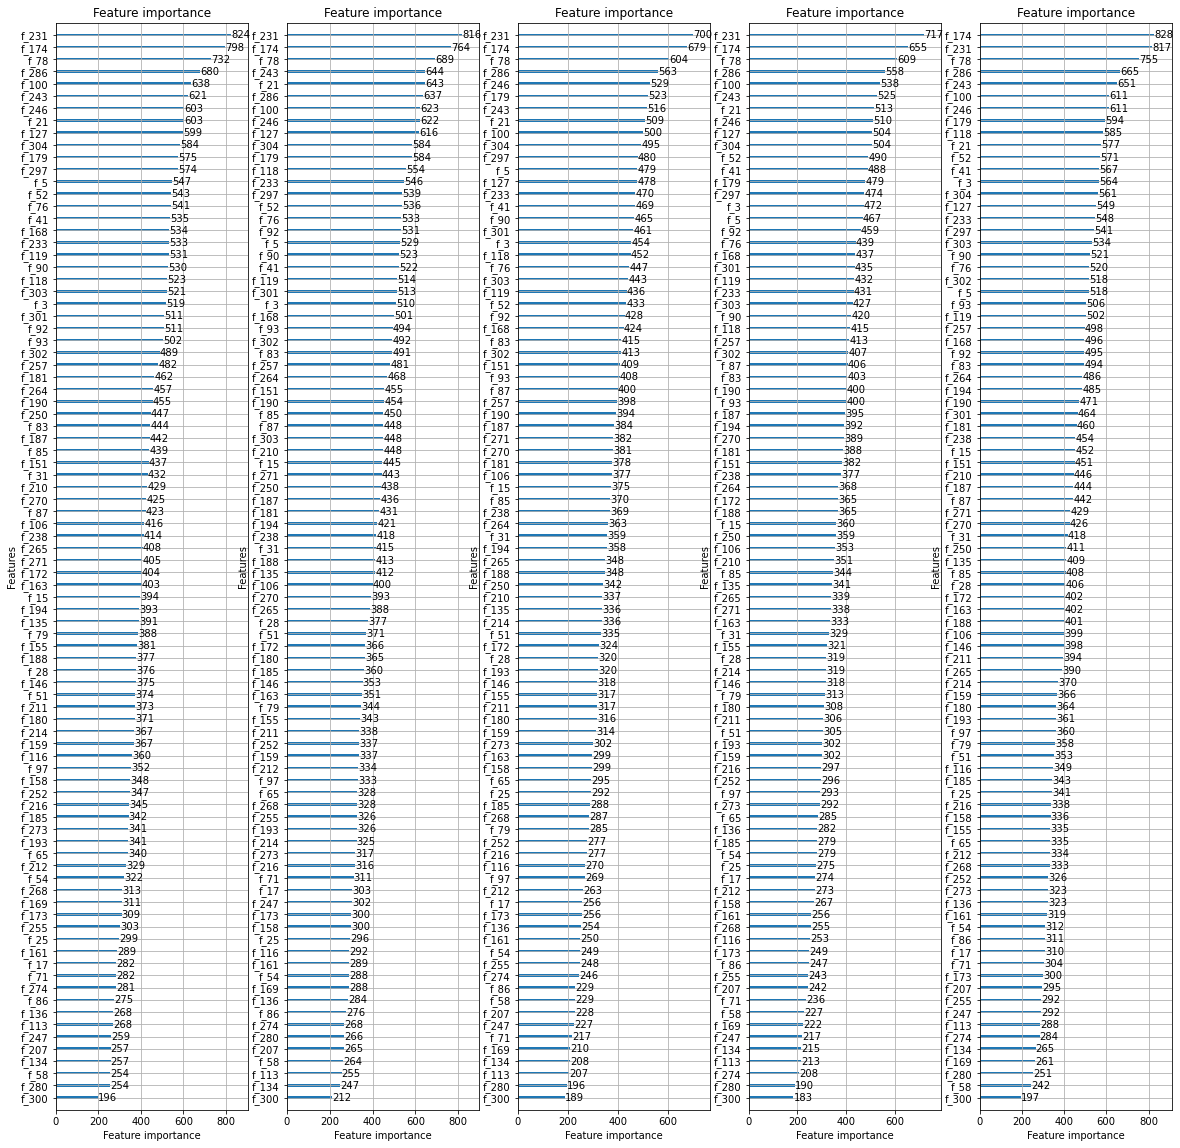

In [43]:
fig = plt.figure(figsize=(20, 20))
for (i, model) in enumerate(best_models_list):
    ax = plt.subplot(1, 5, i+1)
    lgbm.plot_importance(model, max_num_features=100, ax=ax)


In [ ]:
f = open(model_directory/'pickle_best_models_list', 'wb')
pickle.dump(best_models_list, f)
f.close()

In [ ]:
f1 = open(model_directory/'pickle_best_models_list', 'rb')
models_list = pickle.load(f1)